# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
app_root = '../../../../'
test_name = 'test_temp'
datasets_path = os.path.join(app_root, 'data')
model_dir_path = os.path.join(app_root, 'model', test_name)

datasets_paths = {}
for lang in os.listdir(datasets_path):
    dataset_lang_path = os.path.join(datasets_path, lang)
    if os.path.isdir(dataset_lang_path):
        datasets_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            datasets_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'PAD_TOKEN': '<pad>',
    'UNK_TOKEN': '<unk>',
    'transformer_name': "bert-base-cased",
}

# Dataset

In [6]:
from stud.modelsTests.dataset.SRLDataset_transformer import SRLDataset_transformer

In [7]:
dataset_train_en = SRLDataset_transformer(  datasets_paths['EN']['train'], 
                                            tokenizer = global_params['transformer_name'],
                                            baselines_file_path = os.path.join(app_root,'data/baselines.json'))
dataset_train_autogen = SRLDataset_transformer(  datasets_paths['EN']['train_autogenerated'], 
                                            tokenizer = global_params['transformer_name'],
                                            baselines_file_path = os.path.join(app_root,'data/baselines.json'))

In [8]:
SRLDataset_transformer.save_dict(
    os.path.join(model_dir_path, 'labels.npy'), 
    dataset_train_en.labels)

In [9]:
dataset_dev_en = SRLDataset_transformer(datasets_paths['EN']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels)

In [10]:
next(iter(dataset_train_en)).keys()

dict_keys(['dependency_heads', 'dependency_relations', 'lemmas', 'pos_tags', 'predicates', 'roles', 'words', 'predicate_position', 'predicate_label', 'predicate_word'])

In [11]:
global_params.update({ 
    'n_roles_labels': len(dataset_train_en.labels['id_to_roles']),
    'n_predicates_labels': len(dataset_train_en.labels['id_to_predicates'])
})

Saving global variables...

In [12]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

# DataLoader

In [13]:
from torch.utils.data import DataLoader

In [14]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
num_workers = 4

In [15]:
dataloader_train_en = DataLoader(
    dataset_train_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

In [16]:
dataloader_train_autogen_en = DataLoader(
    dataset_train_autogen,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

In [17]:
dataloader_dev_en = DataLoader(
    dataset_dev_en,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

In [18]:
for e in dataloader_dev_en:
    ex_in = e
    break

In [19]:
ex_in.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'roles_formatted', 'matrix_subwords', 'output_mask', 'predicates', 'predicate_position', 'predicate_position_formatted', 'pos_tags'])

In [20]:
for q in dataloader_train_autogen_en:
    ex_qin = q
    break

In [21]:
ex_qin['pos_tags']

tensor([], size=(32, 0))

# Printing model

In [22]:
from stud.modelsTests.utils.print_infos import *

# Trying the autogenerated data

In [23]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

In [24]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_simple import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False,
    loss_fn = loss_function,
    fine_tune_transformer = True,
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
print_summary(final_model.model)

Net_aic_transformer_simple(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [26]:
history = {}

In [27]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_autogen_en, dataloader_dev_en,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.75,
    save_path_name=os.path.join(model_dir_path, 'arg_iden_class_net_weights.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.249256
# Validation loss => 0.134372 | f1-score: arg_iden = 0.758353 arg_class = 0.487512 #
Epoch   1 => avg_loss: 0.117458
# Validation loss => 0.111999 | f1-score: arg_iden = 0.828036 arg_class = 0.591483 #
Epoch   2 => avg_loss: 0.090083
# Validation loss => 0.108806 | f1-score: arg_iden = 0.836639 arg_class = 0.619555 #
Epoch   3 => avg_loss: 0.074539
# Validation loss => 0.106681 | f1-score: arg_iden = 0.842178 arg_class = 0.642533 #
Epoch   4 => avg_loss: 0.063912
# Validation loss => 0.105422 | f1-score: arg_iden = 0.849030 arg_class = 0.659676 #
Epoch   5 => avg_loss: 0.055611
# Validation loss => 0.107264 | f1-score: arg_iden = 0.850039 arg_class = 0.667522 #
Epoch   6 => avg_loss: 0.049300
# Validation loss => 0.111212 | f1-score: arg_iden = 0.846094 arg_class = 0.672606 #
Epoch   7 => avg_loss: 0.044551
# Validation loss => 0.114071 | f1-score: arg_iden = 0.851064 arg_class = 0.676537 #
Epoch   8 => avg_loss: 0.040599
# Validation loss => 0.117876 | 

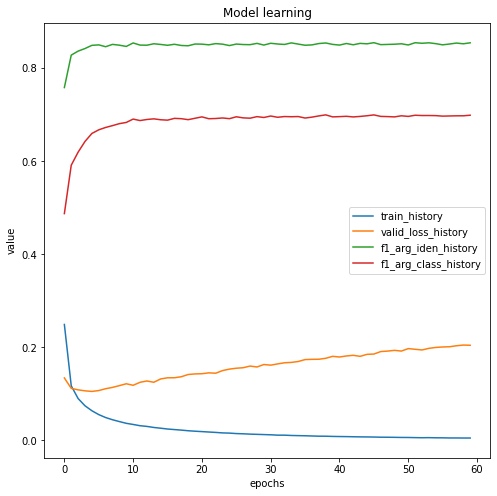

In [28]:
display_history(history)